**THIS NOTEBOOKS CONTAINS EXPLORATARY FORECASTING OF AMOUNT OF SELLERS FOR WHOM ARIMA MODEL IS NOT SUITABLE.**

**To prepare ARIMA there should be at least 100 observations for forecasting the model.**
https://www.researchgate.net/post/What_should_be_the_minimum_number_of_observations_for_a_time_series_model

<font color="red"> **FORECAST FOR SELLER_6**</font>

In [56]:
#Importing the prerequisite libraries that are to be used further.
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.pyplot as plt

**Below is our original csv file**

In [57]:
invoice=pd.read_csv("inv_transdt_transamt_selrid.csv")

In [58]:
invoice.head()

,TransactionDate,SellerId,Trans_amount
0,2019-03-15T00:00:00.000Z,19,10000
1,2017-04-18T00:00:00.000Z,19,5000000
2,2019-07-18T00:00:00.000Z,1,5000
3,2019-07-18T00:00:00.000Z,1,13000
4,2019-07-18T00:00:00.000Z,1,17500


**Following code prepares the time series with index as the Transaction Time and value as amount.**

In [59]:
sel=invoice[invoice.SellerId==6][["TransactionDate","Trans_amount"]]
sel["TransactionDate"]=sel.TransactionDate.apply(lambda x: x.split("T")[0])
sel["TransactionDate"]=pd.to_datetime(sel.TransactionDate)
sel=sel.set_index("TransactionDate")
sel = sel.groupby(pd.Grouper(freq="M")).sum()
sel["Trans_amount"]=sel.Trans_amount.apply(lambda x:int(x))
ts=sel["Trans_amount"]

In [60]:
len(ts)

11

In [61]:
ts.tail()

TransactionDate
2019-01-31    27874703
2019-02-28     8196776
2019-03-31    16854217
2019-04-30    16455700
2019-05-31    24076179
Freq: M, Name: Trans_amount, dtype: int64

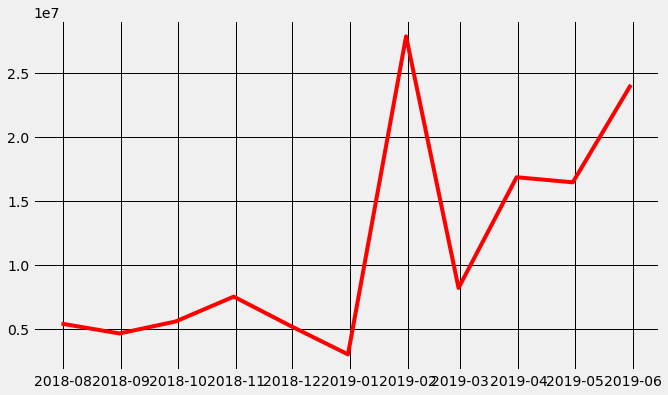

In [62]:
plt.figure(figsize=(10,6))
plt.plot(ts, color="red")
plt.grid(True, color="black")
plt.show()

**Following function is created to test the statioarity of time series, It includes the dickey fuller test.**

In [63]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

**Testing for stationarity**

In [64]:
dft(ts)

Results of Dickey-Fuller Test:
Test Statistic                -0.000000
p-value                        0.958532
#Lags Used                     4.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


*The test_stats is greater than critical values. Hence the series is non stationary.*

**Below is logarithmic transformation of the series which will make little stationary in comparison to non transformed data.**

In [65]:
ts_log=np.log(ts)

**Testing for stationary**

In [66]:
dft(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                 0.000000
p-value                        0.958532
#Lags Used                     4.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


**Here the series is still non stationary**

*Differencing is applied to reduce trend and seasonality from tha data.*

In [67]:
ts_log_diff=ts_log-ts_log.shift()

*Removal of nan values from differencing output*

In [68]:
ts_log_diff.dropna(inplace=True)

**Testing for stationarity**

In [69]:
dft(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -5.959956e+00
p-value                        2.050242e-07
#Lags Used                     0.000000e+00
Number of Observations Used    9.000000e+00
Critical Value (1%)           -4.473135e+00
Critical Value (5%)           -3.289881e+00
Critical Value (10%)          -2.772382e+00
dtype: float64


**Now the test_stats is less 1% critical values i.e. the series is stationary with 99% confidence.**

**APPLYING MOVING AVERAGE MODEL**

In [70]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

In [71]:
model_fit.aic

23.384822747450194

In [72]:
model_fit.bic

24.29257802643233

In [73]:
ts_log_diff.head(10)

TransactionDate
2018-08-31   -0.154166
2018-09-30    0.184376
2018-10-31    0.298941
2018-11-30   -0.358848
2018-12-31   -0.559773
2019-01-31    2.229107
2019-02-28   -1.223979
2019-03-31    0.720860
2019-04-30   -0.023929
2019-05-31    0.380551
Freq: M, Name: Trans_amount, dtype: float64

**Predicting amount for coming 6 months**

In [74]:
pred_mean=model_fit.predict(start="2019-06-30",end="2019-12-31")

In [75]:
pred_mean

2019-06-30   -0.058543
2019-07-31    0.160855
2019-08-31    0.160855
2019-09-30    0.160855
2019-10-31    0.160855
2019-11-30    0.160855
2019-12-31    0.160855
Freq: M, dtype: float64

In [76]:
type(pred_mean)

pandas.core.series.Series

In [77]:
def xyz(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:x)
    return prediction_final

In [78]:
ts_log.tail()

TransactionDate
2019-01-31    17.143230
2019-02-28    15.919251
2019-03-31    16.640111
2019-04-30    16.616182
2019-05-31    16.996733
Freq: M, Name: Trans_amount, dtype: float64

In [79]:
output=xyz(pred_mean, ts_log)

In [80]:
output

2019-05-31    16.996733
2019-06-30    -0.058543
2019-07-31     0.160855
2019-08-31     0.160855
2019-09-30     0.160855
2019-10-31     0.160855
2019-11-30     0.160855
2019-12-31     0.160855
Freq: M, dtype: float64

**Following is the reverse transformation steps to have the forecast into original time series format.**

predictions_ARIMA_diff = pd.Series(pred_mean, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
a=ts_log[-1]
b=a+predictions_ARIMA_diff_cumsum
predictions_ARIMA = np.exp(b)

In [81]:
prediction=output.cumsum()

In [82]:
prediction

2019-05-31    16.996733
2019-06-30    16.938190
2019-07-31    17.099045
2019-08-31    17.259900
2019-09-30    17.420754
2019-10-31    17.581609
2019-11-30    17.742463
2019-12-31    17.903318
Freq: M, dtype: float64

In [83]:
prediction.values

array([16.99673349, 16.93819049, 17.09904501, 17.25989952, 17.42075403,
       17.58160854, 17.74246305, 17.90331756])

In [84]:
forecast=pd.DataFrame()
forecast["Trans_amount"]=prediction
forecast["Trans_amount"]=forecast.Trans_amount.apply(lambda x:x)

**Below is the forecasted amount**

In [85]:
forecast.Trans_amount

2019-05-31    16.996733
2019-06-30    16.938190
2019-07-31    17.099045
2019-08-31    17.259900
2019-09-30    17.420754
2019-10-31    17.581609
2019-11-30    17.742463
2019-12-31    17.903318
Freq: M, Name: Trans_amount, dtype: float64

In [86]:
fin_forecast=np.exp(forecast)

In [87]:
fin_forecast

,Trans_amount
2019-05-31,2.407618e+07
2019-06-30,2.270715e+07
2019-07-31,2.666987e+07
2019-08-31,3.132414e+07
2019-09-30,3.679064e+07
2019-10-31,4.321112e+07
2019-11-30,5.075207e+07
2019-12-31,5.960903e+07


In [88]:
ts.tail()

TransactionDate
2019-01-31    27874703
2019-02-28     8196776
2019-03-31    16854217
2019-04-30    16455700
2019-05-31    24076179
Freq: M, Name: Trans_amount, dtype: int64

In [89]:
fin_forecast

,Trans_amount
2019-05-31,2.407618e+07
2019-06-30,2.270715e+07
2019-07-31,2.666987e+07
2019-08-31,3.132414e+07
2019-09-30,3.679064e+07
2019-10-31,4.321112e+07
2019-11-30,5.075207e+07
2019-12-31,5.960903e+07


**Below is the plot containing our original data and the forecasted values together.**

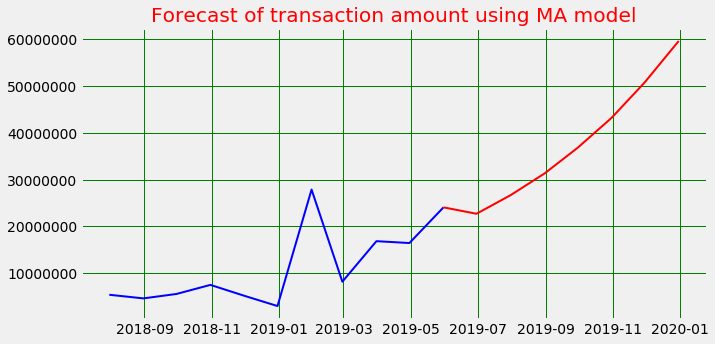

In [92]:
plt.figure(figsize=(10,5))
plt.plot(ts, color="blue", linewidth=2)
plt.plot(fin_forecast,color="red", linewidth=2)
plt.title("Forecast of transaction amount using MA model", color="red")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="green")

<font color="red"> **FORECAST FOR SELLER_3**</font>

**In upcoming codes seller_3 is taken under consideration**

In [372]:
invoice=pd.read_csv("inv_transdt_transamt_selrid.csv")

In [373]:
invoice.head()

,TransactionDate,SellerId,Trans_amount
0,2019-03-15T00:00:00.000Z,19,10000
1,2017-04-18T00:00:00.000Z,19,5000000
2,2019-07-18T00:00:00.000Z,1,5000
3,2019-07-18T00:00:00.000Z,1,13000
4,2019-07-18T00:00:00.000Z,1,17500


In [374]:
sel=invoice[invoice.SellerId==3][["TransactionDate","Trans_amount"]]
sel["TransactionDate"]=sel.TransactionDate.apply(lambda x: x.split("T")[0])
sel["TransactionDate"]=pd.to_datetime(sel.TransactionDate)
sel=sel.set_index("TransactionDate")
sel = sel.groupby(pd.Grouper(freq="M")).sum()
sel["Trans_amount"]=sel.Trans_amount.apply(lambda x:x)
ts=sel["Trans_amount"]

In [375]:
ts.tail()

TransactionDate
2019-03-31      4400
2019-04-30      9600
2019-05-31         0
2019-06-30    262169
2019-07-31    189672
Freq: M, Name: Trans_amount, dtype: int64

**This function takes input as the seller number and gives output the time series well prepared after multiple processes.**

In [200]:
def ts_seller_wise(k):
    sel=invoice[invoice.SellerId==k][["TransactionDate","Trans_amount"]]
    sel["TransactionDate"]=sel.TransactionDate.apply(lambda x: x.split("T")[0])
    sel["TransactionDate"]=pd.to_datetime(sel.TransactionDate)
    sel=sel.set_index("TransactionDate")
    sel = sel.groupby(pd.Grouper(freq="M")).sum()
    sel["Trans_amount"]=sel.Trans_amount.apply(lambda x:int(x))
    ts=sel["Trans_amount"]
    return ts

**Time series for seller_3**

**Test of stationarity**

In [376]:
dft(ts)

Results of Dickey-Fuller Test:
Test Statistic                -0.000000
p-value                        0.958532
#Lags Used                     5.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64


*The output depicts that time series is non stationary.*

**Following is the application of differencing to make the series stationary.**

In [377]:
ts_log=np.log(ts[ts>0])

In [378]:
dft(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.500271
p-value                        0.533377
#Lags Used                     2.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


In [379]:
ts_diff=ts_log-ts_log.shift()

*Removing the na values created during differencing.*

In [380]:
ts_diff.dropna(inplace=True)

**Testing for stationarity.**

In [381]:
dft(ts_diff)

Results of Dickey-Fuller Test:
Test Statistic                -3.111817
p-value                        0.025691
#Lags Used                     0.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


*The series is now stationary with 95 % confidence*.

**Following function takes the forecasted amount as input and converts it into a plot added with plot of original time series.**

In [172]:
def forc_amou(pred_mean):
    predictions_ARIMA_diff = pd.Series(pred_mean, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    a=ts_log[-1]
    predictions_ARIMA=a+predictions_ARIMA_diff_cumsum
    forecast=pd.DataFrame()
    forecast["amount"]=predictions_ARIMA
    forecast["amount"]=forecast.amount.apply(lambda x:int(x))
    plt.figure(figsize=(12,4))
    plt.plot(ts, color="blue", linewidth=2)
    plt.plot(forecast.amount,color="red", linewidth=2)
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.grid(True, color="green")

**AUTOREGRESSIVE MODEL_3**  
*This model forecast by using the regression of current item with past few items.*

In [382]:
from statsmodels.tsa.ar_model import AR
model = AR(ts_diff)
model_fit = model.fit(disp=False)

In [383]:
dft(ts_diff)

Results of Dickey-Fuller Test:
Test Statistic                -3.111817
p-value                        0.025691
#Lags Used                     0.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


In [384]:
ts_diff.tail()

TransactionDate
2019-02-28    0.684482
2019-03-31   -5.562829
2019-04-30    0.780159
2019-06-30    3.307226
2019-07-31   -0.323693
Name: Trans_amount, dtype: float64

In [385]:
model_fit.aic

-60.992361050018516

In [386]:
pred_mean_autoreg=model_fit.predict(start="2019-07-31", end="2019-12-31")

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [225]:
pred_mean_autoreg

2019-07-31   -72497.000000
2019-08-31   -84969.644590
2019-09-30   -32503.464239
2019-10-31    33934.351094
2019-11-30    25261.043797
2019-12-31   -10133.099204
Freq: M, dtype: float64

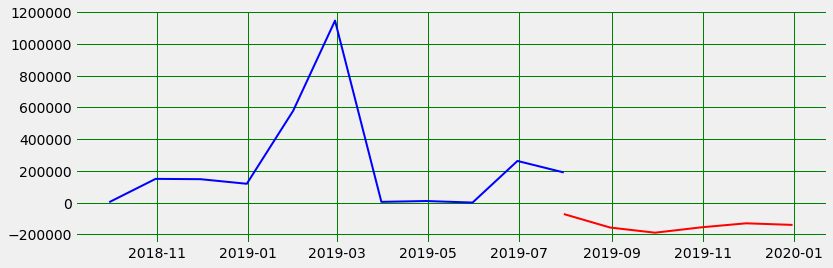

In [226]:
forc_amou(pred_mean_autoreg)

*Above is the forecast of amount using auto regressive model.*

**SIMPLE EXPONENTIAL MODEL_3**  
> *This model is simple exponential smoothing of the series. It computes the exponential mean of given data and forecast the same for any duration.*

*Below code is for computing the forecast of amount for coming 6 months using simple exponential smoothing.*

In [227]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(ts_diff)
model_fit = model.fit()
pred_simple_exponential=model_fit.predict(start="2019-07-31", end="2019-12-31")

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

**Following is the plot portraying the forecast of amount using simple exponential smoothing.**

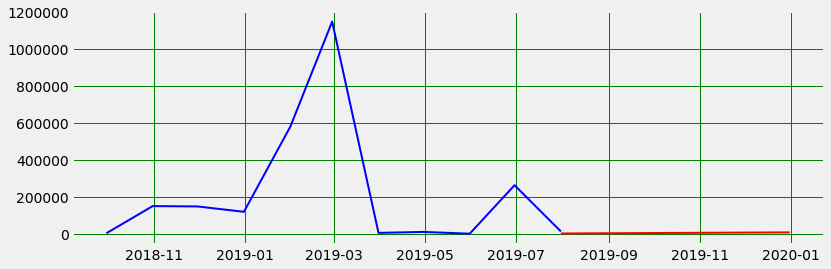

In [54]:
forc_amou(pred_simple_exponential)

**MOVING AVERAGE_3**

**This is moving average model which consideres the mean of preceding items to forecast the future values.**

In [236]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff, order=(0,1))
model_fit = model.fit()
pred_mean_moving_avg=model_fit.predict(start="2019-07-31", end="2019-12-31")

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

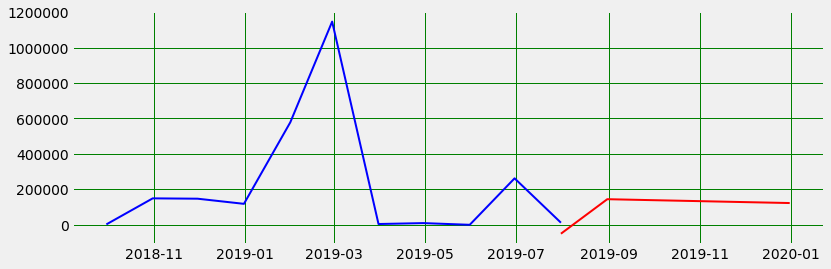

In [56]:
forc_amou(pred_mean_moving_avg)

**AUTOREGRESSIVE MOVING AVERAGE_3**

**This is auto regressive model which performs regression on lagged values of the series.**

In [57]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff, order=(2,1))
model_fit = model.fit()
pred_mean_autoreg_movingavg=model_fit.predict(start="2019-07-31", end="2019-12-31")

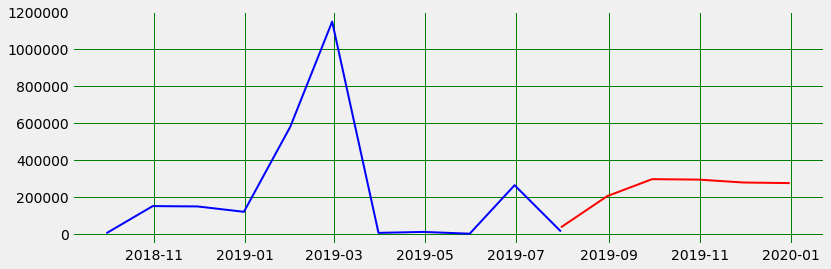

In [58]:
forc_amou(pred_mean_autoreg_movingavg)

**HOLTS LINEAR EXPONENTIAL SMOOTHING_3**  
*This is holts linear smoothing which is a modification of exponential smoothing*

In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(ts)
model_fit = model.fit()
pred_mean_holtslinear_exponential_smoothing=model_fit.predict(start="2019-07-31", end="2019-12-31")

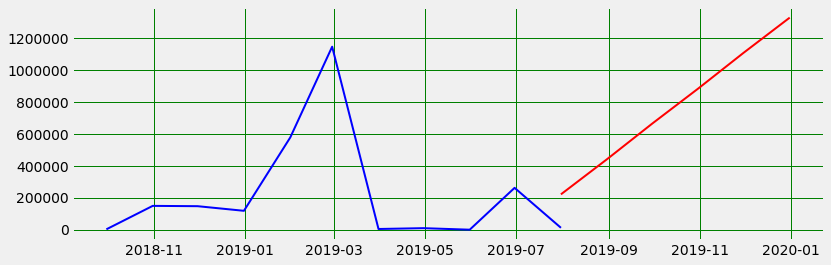

In [60]:
forc_amou(pred_mean_holtslinear_exponential_smoothing)

<font color="red"> **FORECAST FOR SELLER_19** </font>

**Below code will consider seller 19.**  
*Seller_19 has only two positive values. So for this seller the naive mean of two given amounts have been plotted for coming 6 months.*

*This code creates a pandas series of datetime indices for coming 6 months.*

In [61]:
from datetime import datetime
date_rng = pd.date_range(start=pd.to_datetime('2019-07-31'), end=pd.to_datetime("2019-12-31"), freq='M')

In [62]:
date_rng

DatetimeIndex(['2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

**Following is the time series of seller_19**

In [63]:
ts_19=ts_seller_wise(19)

In [64]:
ts_19.head()

TransactionDate
2017-04-30    5000000
2017-05-31          0
2017-06-30          0
2017-07-31          0
2017-08-31          0
Freq: M, Name: Amount, dtype: int64

*Below is mena of amount of given time series which will be forecasted for coming 6 months.*

In [65]:
naive_seller_19=dump[dump.SellerId==19].Amount.mean()

*This is a dataframe containing the amount with the indices to be forecasted.*

In [66]:
df=pd.DataFrame(index=date_rng)
df["amount"]=naive_seller_19

**NAIVE MEAN MODEL SELLER_19**

This is plotting of time series.

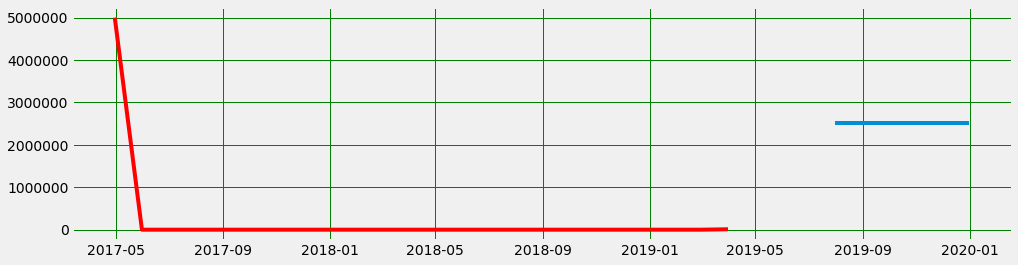

In [67]:
plt.figure(figsize=(15,4))
plt.plot(df)
plt.plot(ts_19, color="red")
plt.grid(True, color="green")

<font color="red"> **FORECAST FOR SELLER_1** </font>

**Below code will consider seller 1.**

In [68]:
ts_1=ts_seller_wise(1)

In [69]:
ts_1

TransactionDate
2018-11-30     1900
2018-12-31    21800
Freq: M, Name: Amount, dtype: int64

*It also has two values. So naive mean will be suitable model for this data too.*

*This code creates a pandas series of datetime indices for coming 6 months.*

In [70]:
from datetime import datetime
date_rng = pd.date_range(start=pd.to_datetime('2019-07-31'), end=pd.to_datetime("2019-12-31"), freq='M')

**Following is the forecast of coming 6 months.**

In [71]:
naive_seller_1=dump[dump.SellerId==1].Amount.mean()

In [72]:
df=pd.DataFrame(index=date_rng)
df["amount"]=naive_seller_1

**NAIVE MEAN MODEL SELLER_1**

**This plot portrays the original and forecasted values for coming 6 monhts.**

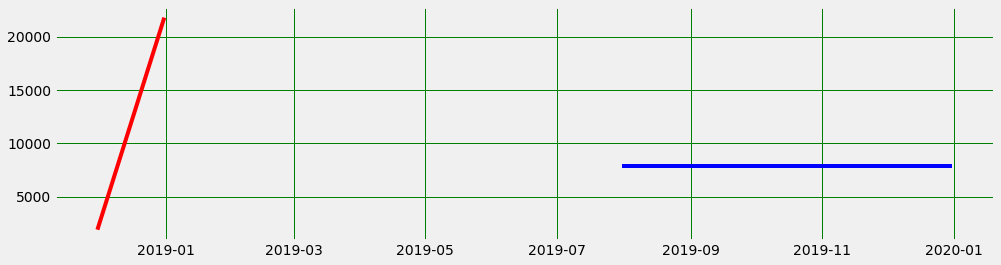

In [73]:
plt.figure(figsize=(15,4))
plt.plot(df, color="blue")
plt.plot(ts_1, color="red")
plt.grid(True, color="green")

In [74]:
sel_13=ts_seller_wise(13)

In [75]:
sel_13

TransactionDate
2015-12-31      554937
2016-01-31      572900
2016-02-29      547166
2016-03-31      992872
2016-04-30      822866
2016-05-31      794288
2016-06-30     1419390
2016-07-31     1677551
2016-08-31     1396583
2016-09-30     1638827
2016-10-31     1697679
2016-11-30     1449077
2016-12-31     1875656
2017-01-31     1935535
2017-02-28     2212570
2017-03-31     2043657
2017-04-30     2430513
2017-05-31     1871103
2017-06-30     2690457
2017-07-31     2328646
2017-08-31     2500392
2017-09-30     2973578
2017-10-31     4012908
2017-11-30     3724928
2017-12-31     4058546
2018-01-31     4633740
2018-02-28     5220998
2018-03-31     4901415
2018-04-30     4721591
2018-05-31     5073155
2018-06-30     6486643
2018-07-31     6476681
2018-08-31     7419291
2018-09-30     6816976
2018-10-31    11555555
2018-11-30    12608596
2018-12-31    14363057
2019-01-31    12699160
2019-02-28    12959233
2019-03-31    14704647
2019-04-30    17594896
2019-05-31    14135376
2019-06-30    1286

In [76]:
train=sel_13.iloc[:35]
test=sel_13.iloc[35:]

In [77]:
test

TransactionDate
2018-11-30    12608596
2018-12-31    14363057
2019-01-31    12699160
2019-02-28    12959233
2019-03-31    14704647
2019-04-30    17594896
2019-05-31    14135376
2019-06-30    12863813
Freq: M, Name: Amount, dtype: int64